# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 6 steps, each in a single notebook:
1. Get probe template
2. Get the Bragg disks
3. **Determine the diffraction shifts**
4. Calculate lattice vectors
5. Calculate strain
6. Visualize strain maps

# Notebook 3: Determine the diffraction shifts

In this step the relative shifts of the diffraction patterns due to the scanning of the beam are calculated, as follows:

* Find unscattered beam positions
    * Get initial guess at unscattered beam position: calculating average deconvolution, take its center of mass
    * Get unscattered beam position in each DP, two ways:
        * (1) Closest disk to the initial guess
        * (2) Highest intensity peak in cross correlation
    * Identify DPs in which methods (1) and (2) agree
* Fit diffraction shifts
    * Fit a plane (or low order polynomial) to calculated diffration shifts, using only DPs where methods (1) and (2) agreed
* Apply shifts and save
    * Apply shifts to Bragg peak list
    * Calculate shift-corrected deconvolution, confirming peaks collapse to Delta functions
    * Save shifts
    * Save shift-corrected Bragg peak list
    * (Optional) Save deconvolution
* (Optional) Create shift-corrected 4D datacube

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit
from time import time

from py4DSTEM.process.datastructure import DataCube, DiffractionSlice, RealSlice, PointList

In [2]:
# # Load the raw data
# fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3"
# dc = py4DSTEM.readwrite.read_data(fp)
# dc.set_scan_shape(60,60)
# dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

In [3]:
# Load data
fp = "/home/ben/Data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5"
dc = py4DSTEM.readwrite.read_data_v0_1(fp)
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

Reading file /home/ben/Data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5...

/home/ben/Data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5 is a py4DSTEM HDF5 file.  Reading...


In [4]:
# # Load the Bragg peak positions
# fp_Braggpeaks = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/Bragg_disks.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_Braggpeaks)
# browser.show_dataobjects()
# Bragg_peak_point_list = browser.get_dataobject(0)

In [5]:
# Load the Bragg peak positions
fp_Braggpeaks = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Bragg_disks.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_Braggpeaks)
browser.show_dataobjects()
Bragg_peak_point_list = browser.get_dataobject(0)

 Index                  Name                        Type        
   0    Bragg_disks                         PointList           


### Find unscattered beam positions

In [6]:
# Get the average deconvolution

average_deconvolution = DiffractionSlice(data=np.zeros((dc.Q_Ny,dc.Q_Nx)), parentDataCube=dc)

for i in range(len(Bragg_peak_point_list.data)):
    qx = int(Bragg_peak_point_list.data['qx'][i])
    qy = int(Bragg_peak_point_list.data['qy'][i])
    average_deconvolution.data2D[qx,qy] += Bragg_peak_point_list.data['intensity'][i]

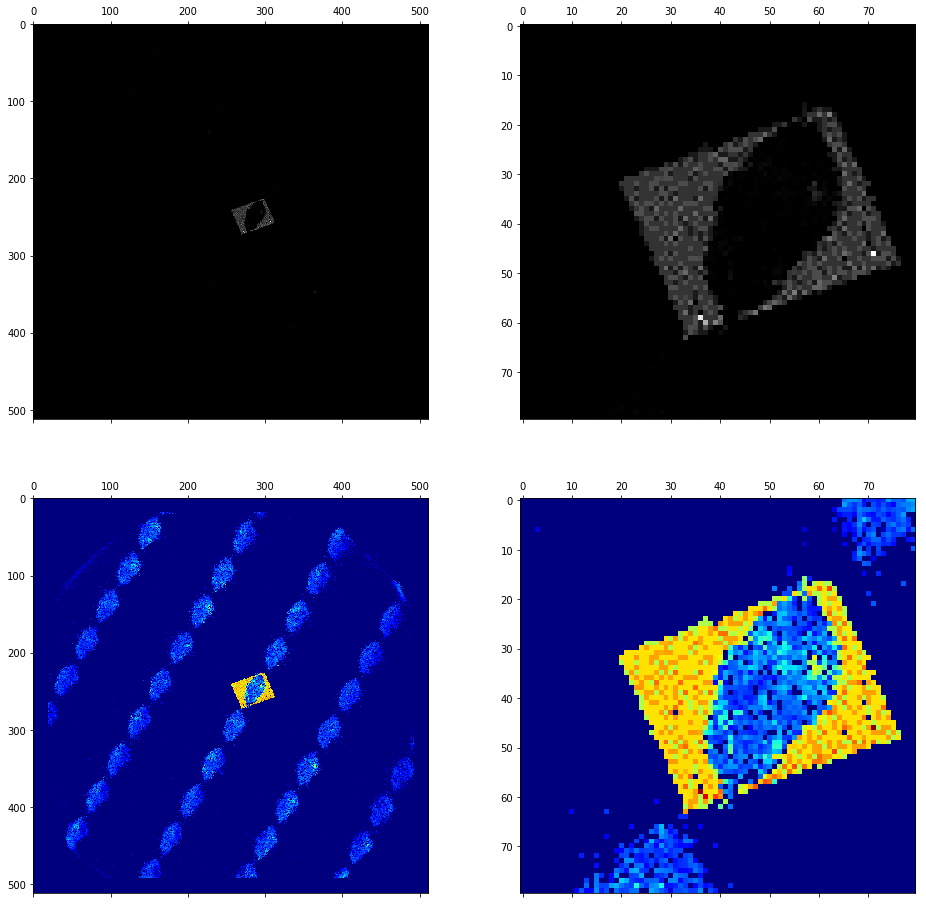

In [7]:
# Plot

x0,y0=py4DSTEM.process.utils.get_CoM(average_deconvolution.data2D)
x0,y0=int(x0),int(y0)
rad=40

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(16,16))
ax11.matshow(average_deconvolution.data2D)
ax12.matshow(average_deconvolution.data2D[x0-rad:x0+rad,y0-rad:y0+rad])
ax21.matshow(average_deconvolution.data2D**0.25,cmap='jet')
ax22.matshow(average_deconvolution.data2D[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

In [8]:
# Get average central beam position, from CoM of average deconvolution

central_beam_qx0, central_beam_qy0 = py4DSTEM.process.utils.get_CoM(average_deconvolution.data2D)

In [9]:
# Get the diffraction shifts for each DP. Use two methods:
# (1) closest peak to CoM of average deconvolution, and
# (2) brightest cross correlation peak

diffraction_shifts_intensity = RealSlice(data=np.empty((2,dc.R_Nx,dc.R_Ny)),
                                         parentDataCube=dc,slicelabels=('x','y'))
diffraction_shifts_position = RealSlice(data=np.empty((2,dc.R_Nx,dc.R_Ny))
                                        ,parentDataCube=dc,slicelabels=('x','y'))

for Ri in range(dc.R_Nx):
    for Rj in range(dc.R_Ny):
        Rij_point_list = Bragg_peak_point_list.get_subpointlist([('rx',Ri),('ry',Rj)])
        
        index = np.argmax(Rij_point_list.data['intensity'])
        diffraction_shifts_intensity.data2D['x'][Ri,Rj] = Rij_point_list.data['qx'][index]
        diffraction_shifts_intensity.data2D['y'][Ri,Rj] = Rij_point_list.data['qy'][index]
        
        r2 = (Rij_point_list.data['qx']-central_beam_qx0)**2 + (Rij_point_list.data['qy']-central_beam_qy0)**2
        index = np.argmin(r2)
        diffraction_shifts_position.data2D['x'][Ri,Rj] = Rij_point_list.data['qx'][index]
        diffraction_shifts_position.data2D['y'][Ri,Rj] = Rij_point_list.data['qy'][index]

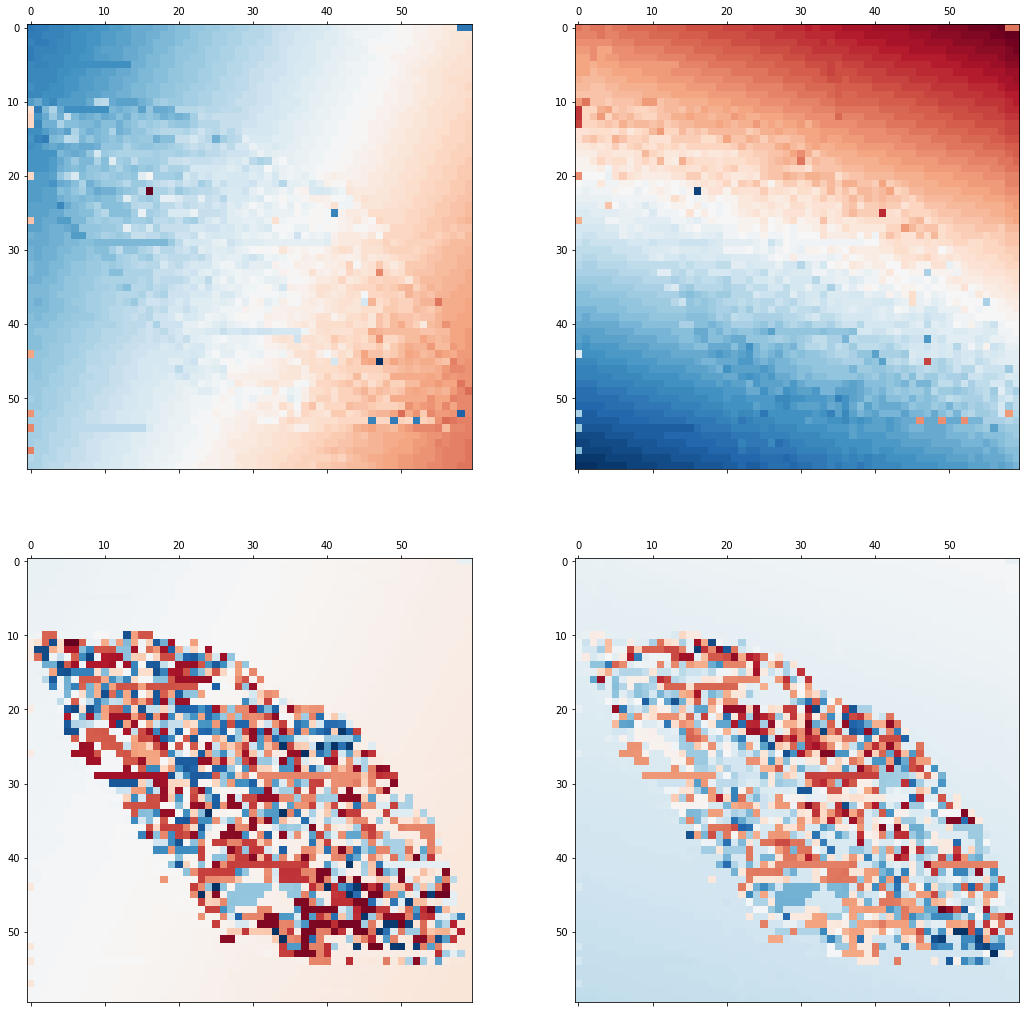

In [10]:
# Plot shifts

fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(18,18))
ax11.matshow(diffraction_shifts_position.data2D['x'],cmap="RdBu")
ax12.matshow(diffraction_shifts_position.data2D['y'],cmap="RdBu")
ax21.matshow(diffraction_shifts_intensity.data2D['x'],cmap="RdBu")
ax22.matshow(diffraction_shifts_intensity.data2D['y'],cmap="RdBu")
plt.show()

In [11]:
# Identify probe positions where Bragg peak identified as central disk agrees using either method of identification
# Create mask corresponding to where we are most confident the central peak has been correctly determined

diffraction_shifts = RealSlice(data=np.zeros((3,dc.R_Nx,dc.R_Ny)),
                               parentDataCube=dc,slicelabels=('x','y','known_mask'))
diffraction_shifts.data2D['known_mask'] = diffraction_shifts.data2D['known_mask'].astype(bool)

for Ri in range(dc.R_Nx):
    for Rj in range(dc.R_Ny):
        Rij_point_list = Bragg_peak_point_list.get_subpointlist([('rx',Ri),('ry',Rj)])
        
        r2 = (Rij_point_list.data['qx']-central_beam_qx0)**2 + (Rij_point_list.data['qy']-central_beam_qy0)**2
        index1 = np.argmin(r2)
        index2 = np.argmax(Rij_point_list.data['intensity'])
        
        if index1 == index2:
            diffraction_shifts.data2D['x'][Ri,Rj] = Rij_point_list.data['qx'][index1]
            diffraction_shifts.data2D['y'][Ri,Rj] = Rij_point_list.data['qy'][index1]
            diffraction_shifts.data2D['known_mask'][Ri,Rj] = True

In [12]:
# Subtract off average from diffraction shifts

diffraction_shifts.data2D['x']=diffraction_shifts.data2D['x']-np.average(diffraction_shifts.data2D['x'][diffraction_shifts.data2D['known_mask']])
diffraction_shifts.data2D['y']=diffraction_shifts.data2D['y']-np.average(diffraction_shifts.data2D['y'][diffraction_shifts.data2D['known_mask']])

diffraction_shifts.data2D['x'][diffraction_shifts.data2D['known_mask']==False] = 0
diffraction_shifts.data2D['y'][diffraction_shifts.data2D['known_mask']==False] = 0

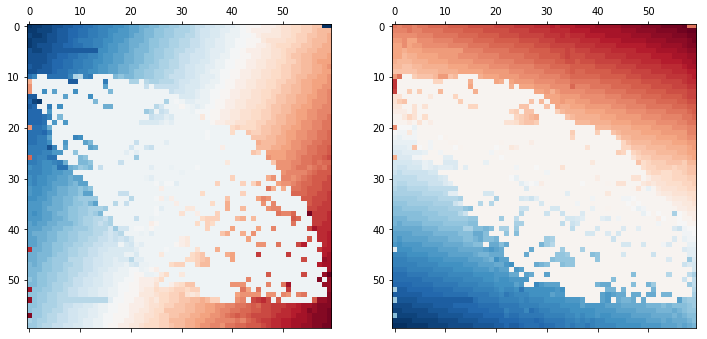

In [13]:
# Plot known shifts

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,18))
ax1.matshow(diffraction_shifts.data2D['x'],cmap="RdBu")
ax2.matshow(diffraction_shifts.data2D['y'],cmap="RdBu")
plt.show()

### Fit diffraction shifts

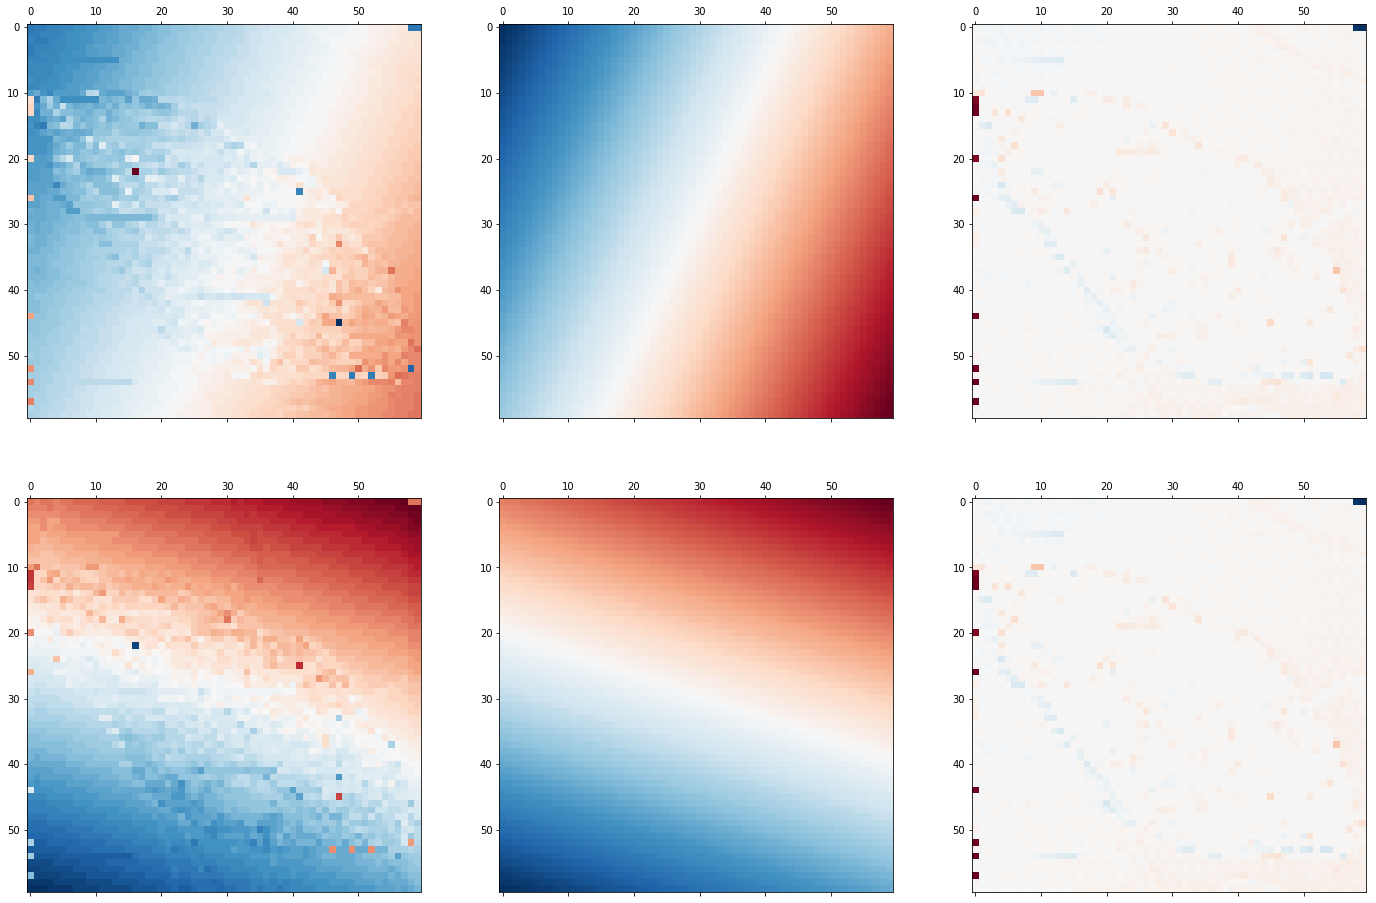

In [14]:
# Fit with diffraction shifts determined by positions (method 1)

fit_function = py4DSTEM.process.fit.plane

diffraction_shifts_fit_all = RealSlice(data=np.zeros((2,dc.R_Nx,dc.R_Ny)),
                                       parentDataCube=dc,slicelabels=('x','y'))

popt_x, pcov_x, diffraction_shifts_fit_all.data2D['x'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts_position.data2D['x'])
popt_y, pcov_y, diffraction_shifts_fit_all.data2D['y'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts_position.data2D['y'])

residuals_x = diffraction_shifts_position.data2D['x']-diffraction_shifts_fit_all.data2D['x']
residuals_x[diffraction_shifts.data2D['known_mask']==False] = 0
residuals_y = diffraction_shifts_position.data2D['x']-diffraction_shifts_fit_all.data2D['x']
residuals_y[diffraction_shifts.data2D['known_mask']==False] = 0

fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,16))
ax11.matshow(diffraction_shifts_position.data2D['x'],cmap="RdBu")
ax12.matshow(diffraction_shifts_fit_all.data2D['x'],cmap="RdBu")
ax13.matshow(residuals_x,cmap="RdBu")
ax21.matshow(diffraction_shifts_position.data2D['y'],cmap="RdBu")
ax22.matshow(diffraction_shifts_fit_all.data2D['y'],cmap="RdBu")
ax23.matshow(residuals_y,cmap="RdBu")
plt.show()

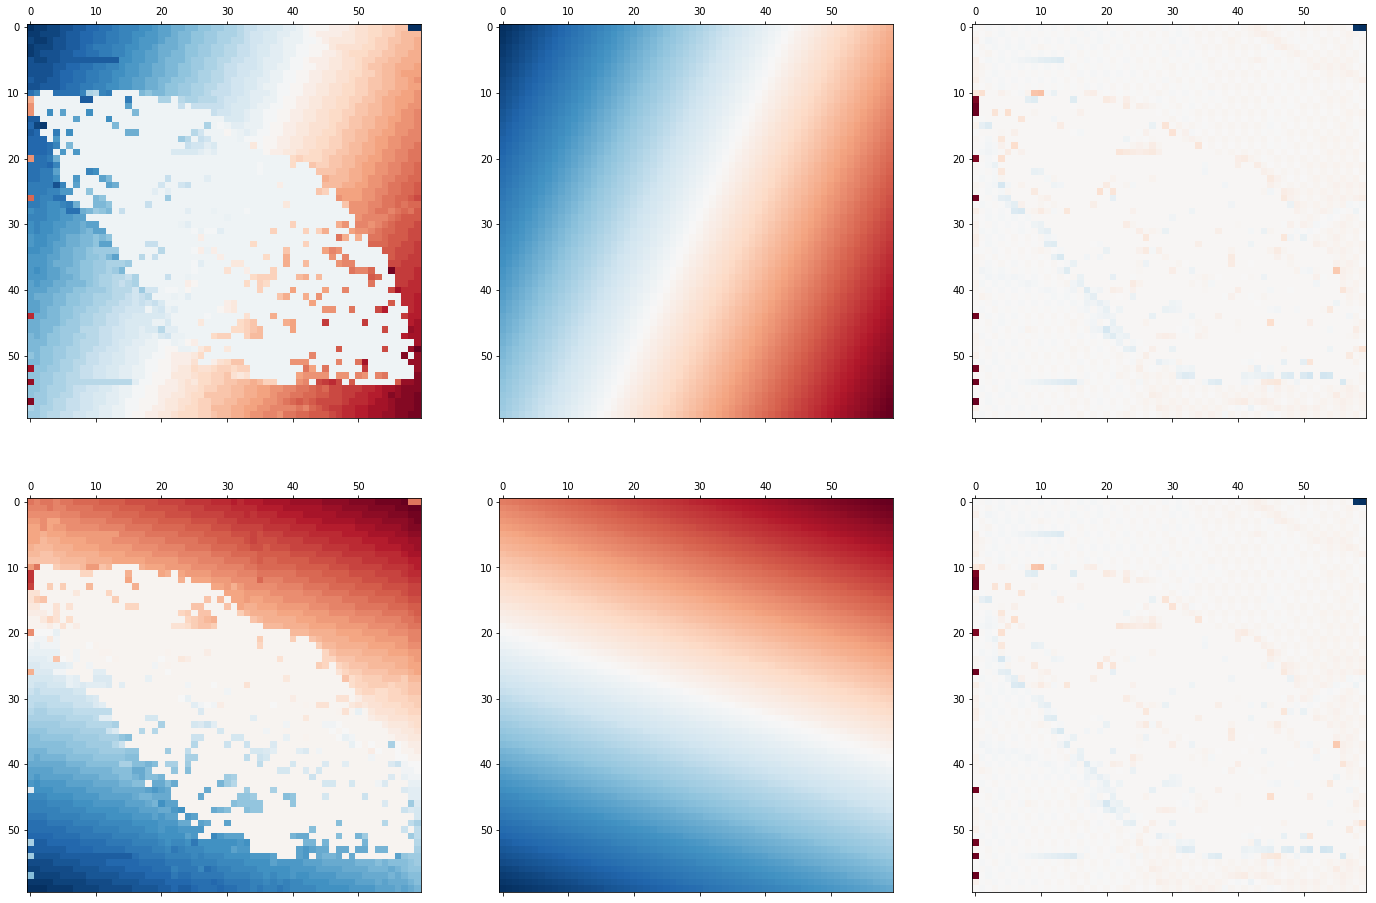

In [15]:
# Fit with only datapoints where diffraction_shifts_known==True

fit_function = py4DSTEM.process.fit.plane

diffraction_shifts_fit = RealSlice(data=np.zeros((2,dc.R_Nx,dc.R_Ny)),
                                    parentDataCube=dc,slicelabels=('x','y'))

popt_x, pcov_x, diffraction_shifts_fit.data2D['x'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts.data2D['x'], data_mask=diffraction_shifts.data2D['known_mask'])
popt_y, pcov_y, diffraction_shifts_fit.data2D['y'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts.data2D['y'], data_mask=diffraction_shifts.data2D['known_mask'])

residuals_x = diffraction_shifts.data2D['x']-diffraction_shifts_fit.data2D['x']
residuals_x[diffraction_shifts.data2D['known_mask']==False] = 0
residuals_y = diffraction_shifts.data2D['x']-diffraction_shifts_fit.data2D['x']
residuals_y[diffraction_shifts.data2D['known_mask']==False] = 0

fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,16))
ax11.matshow(diffraction_shifts.data2D['x'],cmap="RdBu")
ax12.matshow(diffraction_shifts_fit.data2D['x'],cmap="RdBu")
ax13.matshow(residuals_x,cmap="RdBu")
ax21.matshow(diffraction_shifts.data2D['y'],cmap="RdBu")
ax22.matshow(diffraction_shifts_fit.data2D['y'],cmap="RdBu")
ax23.matshow(residuals_y,cmap="RdBu")
plt.show()

### Apply shifts and save

In [25]:
# Apply shifts to Bragg peak list

coords = [('rx',float),('ry',float),('qx',float),('qy',float),('intensity',float)]
Bragg_peaks_shift_corrected = PointList(coordinates=coords, parentDataCube=dc, name="Bragg_disks__shift_corrected")

for i in range(len(Bragg_peak_point_list.data['rx'])):
    rx = int(Bragg_peak_point_list.data['rx'][i])
    ry = int(Bragg_peak_point_list.data['ry'][i])
    shift_qx = int(diffraction_shifts_fit.data2D['x'][rx,ry])
    shift_qy = int(diffraction_shifts_fit.data2D['y'][rx,ry])
    qx = int(Bragg_peak_point_list.data['qx'][i]) - shift_qx
    qy = int(Bragg_peak_point_list.data['qy'][i]) - shift_qy
    intensity = Bragg_peak_point_list.data['intensity'][i]

    new_point = (rx, ry, qx, qy, intensity)
    Bragg_peaks_shift_corrected.add_point(new_point)

In [26]:
# Calculate shift-corrected deconvolution

deconvolution = DiffractionSlice(data=np.zeros((dc.Q_Ny,dc.Q_Nx)), parentDataCube=dc)

for i in range(len(Bragg_peaks_shift_corrected.data['rx'])):
    rx = int(Bragg_peaks_shift_corrected.data['rx'][i])
    ry = int(Bragg_peaks_shift_corrected.data['ry'][i])
    qx = int(Bragg_peaks_shift_corrected.data['qx'][i])
    qy = int(Bragg_peaks_shift_corrected.data['qy'][i])

    deconvolution.data2D[qx,qy] += Bragg_peaks_shift_corrected.data['intensity'][i]

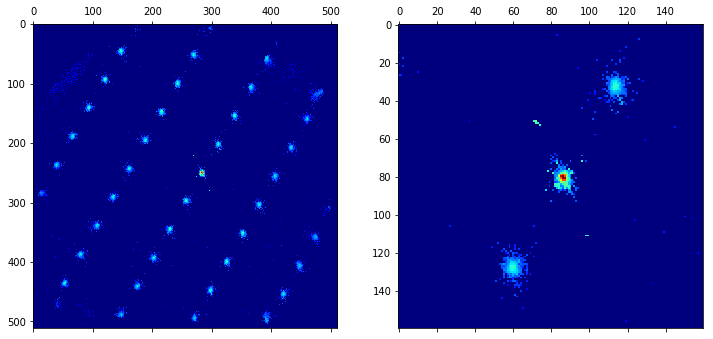

In [27]:
# Plot deconvolution, confirming peaks collapse to Delta functions

x0,y0=py4DSTEM.process.utils.get_CoM(deconvolution.data2D)
x0,y0=int(x0),int(y0)
rad=80

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,12))
ax1.matshow(deconvolution.data2D**0.15,cmap='jet')
ax2.matshow(deconvolution.data2D[x0-rad:x0+rad,y0-rad:y0+rad]**0.15,cmap='jet')
plt.show()

In [28]:
# # Save diffraction shifts
# savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/diffraction_shifts.h5"
# py4DSTEM.readwrite.save_dataobject(diffraction_shifts_fit,savepath)

In [29]:
# Save diffraction shifts
savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/diffraction_shifts.h5"
py4DSTEM.readwrite.save_dataobject(diffraction_shifts_fit,savepath)

Creating file /home/ben/Data/20180905_FePO4_unlithiated/processing/diffraction_shifts.h5...
Writing metadata...
Done.


In [30]:
# # Save shift-corrected Bragg peak list
# savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/Bragg_disks__shift_corrected.h5"
# py4DSTEM.readwrite.save_dataobject(Bragg_peaks_shift_corrected,savepath)

In [31]:
# Save shift-corrected Bragg peak list
savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Bragg_disks__shift_corrected.h5"
py4DSTEM.readwrite.save_dataobject(Bragg_peaks_shift_corrected,savepath)

Creating file /home/ben/Data/20180905_FePO4_unlithiated/processing/Bragg_disks__shift_corrected.h5...
Writing metadata...
Done.


In [32]:
# # (optional) Save deconvolution
# # Save diffraction shifts
# savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/deconvolution.h5"
# py4DSTEM.readwrite.save_dataobject(deconvolution,savepath)

In [33]:
# # (optional) Save deconvolution
# # Save diffraction shifts
# savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/deconvolution.h5"
# py4DSTEM.readwrite.save_dataobject(deconvolution,savepath)

In [34]:
# (optional) Save deconvolution
# Save diffraction shifts
savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/deconvolution.h5"
py4DSTEM.readwrite.save_dataobject(deconvolution,savepath)

Creating file /home/ben/Data/20180905_FePO4_unlithiated/processing/deconvolution.h5...
Writing metadata...
Done.


### (Optional) Create shift-corrected 4D datacube

In [58]:
# Apply shifts

data4D_corrected = np.empty_like(dc.data4D,dtype='float32')

t0=time()
for i in range(dc.R_Nx):
    for j in range(dc.R_Ny):
        print("Shifting DP from scan position {},{}".format(i,j))
        data4D_corrected[i,j,:,:] = py4DSTEM.process.utils.get_shifted_ar(dc.data4D[i,j,:,:], 
                                                   -diffraction_shifts_fit.data2D['x'][i,j],
                                                   -diffraction_shifts_fit.data2D['y'][i,j])

t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Shifting DP from scan position 0,0
Shifting DP from scan position 0,1
Shifting DP from scan position 0,2
Shifting DP from scan position 0,3
Shifting DP from scan position 0,4
Shifting DP from scan position 0,5
Shifting DP from scan position 0,6
Shifting DP from scan position 0,7
Shifting DP from scan position 0,8
Shifting DP from scan position 0,9
Shifting DP from scan position 0,10
Shifting DP from scan position 0,11
Shifting DP from scan position 0,12
Shifting DP from scan position 0,13
Shifting DP from scan position 0,14
Shifting DP from scan position 0,15
Shifting DP from scan position 0,16
Shifting DP from scan position 0,17
Shifting DP from scan position 0,18
Shifting DP from scan position 0,19
Shifting DP from scan position 0,20
Shifting DP from scan position 0,21
Shifting DP from scan position 0,22
Shifting DP from scan position 0,23
Shifting DP from scan position 0,24
Shifting DP from scan position 0,25
Shifting DP from scan position 0,26
Shifting DP from scan position 0,27
Sh

Shifting DP from scan position 3,53
Shifting DP from scan position 3,54
Shifting DP from scan position 3,55
Shifting DP from scan position 3,56
Shifting DP from scan position 3,57
Shifting DP from scan position 3,58
Shifting DP from scan position 3,59
Shifting DP from scan position 4,0
Shifting DP from scan position 4,1
Shifting DP from scan position 4,2
Shifting DP from scan position 4,3
Shifting DP from scan position 4,4
Shifting DP from scan position 4,5
Shifting DP from scan position 4,6
Shifting DP from scan position 4,7
Shifting DP from scan position 4,8
Shifting DP from scan position 4,9
Shifting DP from scan position 4,10
Shifting DP from scan position 4,11
Shifting DP from scan position 4,12
Shifting DP from scan position 4,13
Shifting DP from scan position 4,14
Shifting DP from scan position 4,15
Shifting DP from scan position 4,16
Shifting DP from scan position 4,17
Shifting DP from scan position 4,18
Shifting DP from scan position 4,19
Shifting DP from scan position 4,20
Sh

Shifting DP from scan position 7,43
Shifting DP from scan position 7,44
Shifting DP from scan position 7,45
Shifting DP from scan position 7,46
Shifting DP from scan position 7,47
Shifting DP from scan position 7,48
Shifting DP from scan position 7,49
Shifting DP from scan position 7,50
Shifting DP from scan position 7,51
Shifting DP from scan position 7,52
Shifting DP from scan position 7,53
Shifting DP from scan position 7,54
Shifting DP from scan position 7,55
Shifting DP from scan position 7,56
Shifting DP from scan position 7,57
Shifting DP from scan position 7,58
Shifting DP from scan position 7,59
Shifting DP from scan position 8,0
Shifting DP from scan position 8,1
Shifting DP from scan position 8,2
Shifting DP from scan position 8,3
Shifting DP from scan position 8,4
Shifting DP from scan position 8,5
Shifting DP from scan position 8,6
Shifting DP from scan position 8,7
Shifting DP from scan position 8,8
Shifting DP from scan position 8,9
Shifting DP from scan position 8,10
Sh

Shifting DP from scan position 11,31
Shifting DP from scan position 11,32
Shifting DP from scan position 11,33
Shifting DP from scan position 11,34
Shifting DP from scan position 11,35
Shifting DP from scan position 11,36
Shifting DP from scan position 11,37
Shifting DP from scan position 11,38
Shifting DP from scan position 11,39
Shifting DP from scan position 11,40
Shifting DP from scan position 11,41
Shifting DP from scan position 11,42
Shifting DP from scan position 11,43
Shifting DP from scan position 11,44
Shifting DP from scan position 11,45
Shifting DP from scan position 11,46
Shifting DP from scan position 11,47
Shifting DP from scan position 11,48
Shifting DP from scan position 11,49
Shifting DP from scan position 11,50
Shifting DP from scan position 11,51
Shifting DP from scan position 11,52
Shifting DP from scan position 11,53
Shifting DP from scan position 11,54
Shifting DP from scan position 11,55
Shifting DP from scan position 11,56
Shifting DP from scan position 11,57
S

Shifting DP from scan position 15,19
Shifting DP from scan position 15,20
Shifting DP from scan position 15,21
Shifting DP from scan position 15,22
Shifting DP from scan position 15,23
Shifting DP from scan position 15,24
Shifting DP from scan position 15,25
Shifting DP from scan position 15,26
Shifting DP from scan position 15,27
Shifting DP from scan position 15,28
Shifting DP from scan position 15,29
Shifting DP from scan position 15,30
Shifting DP from scan position 15,31
Shifting DP from scan position 15,32
Shifting DP from scan position 15,33
Shifting DP from scan position 15,34
Shifting DP from scan position 15,35
Shifting DP from scan position 15,36
Shifting DP from scan position 15,37
Shifting DP from scan position 15,38
Shifting DP from scan position 15,39
Shifting DP from scan position 15,40
Shifting DP from scan position 15,41
Shifting DP from scan position 15,42
Shifting DP from scan position 15,43
Shifting DP from scan position 15,44
Shifting DP from scan position 15,45
S

Shifting DP from scan position 19,2
Shifting DP from scan position 19,3
Shifting DP from scan position 19,4
Shifting DP from scan position 19,5
Shifting DP from scan position 19,6
Shifting DP from scan position 19,7
Shifting DP from scan position 19,8
Shifting DP from scan position 19,9
Shifting DP from scan position 19,10
Shifting DP from scan position 19,11
Shifting DP from scan position 19,12
Shifting DP from scan position 19,13
Shifting DP from scan position 19,14
Shifting DP from scan position 19,15
Shifting DP from scan position 19,16
Shifting DP from scan position 19,17
Shifting DP from scan position 19,18
Shifting DP from scan position 19,19
Shifting DP from scan position 19,20
Shifting DP from scan position 19,21
Shifting DP from scan position 19,22
Shifting DP from scan position 19,23
Shifting DP from scan position 19,24
Shifting DP from scan position 19,25
Shifting DP from scan position 19,26
Shifting DP from scan position 19,27
Shifting DP from scan position 19,28
Shifting 

Shifting DP from scan position 22,49
Shifting DP from scan position 22,50
Shifting DP from scan position 22,51
Shifting DP from scan position 22,52
Shifting DP from scan position 22,53
Shifting DP from scan position 22,54
Shifting DP from scan position 22,55
Shifting DP from scan position 22,56
Shifting DP from scan position 22,57
Shifting DP from scan position 22,58
Shifting DP from scan position 22,59
Shifting DP from scan position 23,0
Shifting DP from scan position 23,1
Shifting DP from scan position 23,2
Shifting DP from scan position 23,3
Shifting DP from scan position 23,4
Shifting DP from scan position 23,5
Shifting DP from scan position 23,6
Shifting DP from scan position 23,7
Shifting DP from scan position 23,8
Shifting DP from scan position 23,9
Shifting DP from scan position 23,10
Shifting DP from scan position 23,11
Shifting DP from scan position 23,12
Shifting DP from scan position 23,13
Shifting DP from scan position 23,14
Shifting DP from scan position 23,15
Shifting DP

Shifting DP from scan position 26,34
Shifting DP from scan position 26,35
Shifting DP from scan position 26,36
Shifting DP from scan position 26,37
Shifting DP from scan position 26,38
Shifting DP from scan position 26,39
Shifting DP from scan position 26,40
Shifting DP from scan position 26,41
Shifting DP from scan position 26,42
Shifting DP from scan position 26,43
Shifting DP from scan position 26,44
Shifting DP from scan position 26,45
Shifting DP from scan position 26,46
Shifting DP from scan position 26,47
Shifting DP from scan position 26,48
Shifting DP from scan position 26,49
Shifting DP from scan position 26,50
Shifting DP from scan position 26,51
Shifting DP from scan position 26,52
Shifting DP from scan position 26,53
Shifting DP from scan position 26,54
Shifting DP from scan position 26,55
Shifting DP from scan position 26,56
Shifting DP from scan position 26,57
Shifting DP from scan position 26,58
Shifting DP from scan position 26,59
Shifting DP from scan position 27,0
Sh

Shifting DP from scan position 30,22
Shifting DP from scan position 30,23
Shifting DP from scan position 30,24
Shifting DP from scan position 30,25
Shifting DP from scan position 30,26
Shifting DP from scan position 30,27
Shifting DP from scan position 30,28
Shifting DP from scan position 30,29
Shifting DP from scan position 30,30
Shifting DP from scan position 30,31
Shifting DP from scan position 30,32
Shifting DP from scan position 30,33
Shifting DP from scan position 30,34
Shifting DP from scan position 30,35
Shifting DP from scan position 30,36
Shifting DP from scan position 30,37
Shifting DP from scan position 30,38
Shifting DP from scan position 30,39
Shifting DP from scan position 30,40
Shifting DP from scan position 30,41
Shifting DP from scan position 30,42
Shifting DP from scan position 30,43
Shifting DP from scan position 30,44
Shifting DP from scan position 30,45
Shifting DP from scan position 30,46
Shifting DP from scan position 30,47
Shifting DP from scan position 30,48
S

Shifting DP from scan position 34,10
Shifting DP from scan position 34,11
Shifting DP from scan position 34,12
Shifting DP from scan position 34,13
Shifting DP from scan position 34,14
Shifting DP from scan position 34,15
Shifting DP from scan position 34,16
Shifting DP from scan position 34,17
Shifting DP from scan position 34,18
Shifting DP from scan position 34,19
Shifting DP from scan position 34,20
Shifting DP from scan position 34,21
Shifting DP from scan position 34,22
Shifting DP from scan position 34,23
Shifting DP from scan position 34,24
Shifting DP from scan position 34,25
Shifting DP from scan position 34,26
Shifting DP from scan position 34,27
Shifting DP from scan position 34,28
Shifting DP from scan position 34,29
Shifting DP from scan position 34,30
Shifting DP from scan position 34,31
Shifting DP from scan position 34,32
Shifting DP from scan position 34,33
Shifting DP from scan position 34,34
Shifting DP from scan position 34,35
Shifting DP from scan position 34,36
S

Shifting DP from scan position 37,56
Shifting DP from scan position 37,57
Shifting DP from scan position 37,58
Shifting DP from scan position 37,59
Shifting DP from scan position 38,0
Shifting DP from scan position 38,1
Shifting DP from scan position 38,2
Shifting DP from scan position 38,3
Shifting DP from scan position 38,4
Shifting DP from scan position 38,5
Shifting DP from scan position 38,6
Shifting DP from scan position 38,7
Shifting DP from scan position 38,8
Shifting DP from scan position 38,9
Shifting DP from scan position 38,10
Shifting DP from scan position 38,11
Shifting DP from scan position 38,12
Shifting DP from scan position 38,13
Shifting DP from scan position 38,14
Shifting DP from scan position 38,15
Shifting DP from scan position 38,16
Shifting DP from scan position 38,17
Shifting DP from scan position 38,18
Shifting DP from scan position 38,19
Shifting DP from scan position 38,20
Shifting DP from scan position 38,21
Shifting DP from scan position 38,22
Shifting DP

Shifting DP from scan position 41,42
Shifting DP from scan position 41,43
Shifting DP from scan position 41,44
Shifting DP from scan position 41,45
Shifting DP from scan position 41,46
Shifting DP from scan position 41,47
Shifting DP from scan position 41,48
Shifting DP from scan position 41,49
Shifting DP from scan position 41,50
Shifting DP from scan position 41,51
Shifting DP from scan position 41,52
Shifting DP from scan position 41,53
Shifting DP from scan position 41,54
Shifting DP from scan position 41,55
Shifting DP from scan position 41,56
Shifting DP from scan position 41,57
Shifting DP from scan position 41,58
Shifting DP from scan position 41,59
Shifting DP from scan position 42,0
Shifting DP from scan position 42,1
Shifting DP from scan position 42,2
Shifting DP from scan position 42,3
Shifting DP from scan position 42,4
Shifting DP from scan position 42,5
Shifting DP from scan position 42,6
Shifting DP from scan position 42,7
Shifting DP from scan position 42,8
Shifting D

Shifting DP from scan position 45,29
Shifting DP from scan position 45,30
Shifting DP from scan position 45,31
Shifting DP from scan position 45,32
Shifting DP from scan position 45,33
Shifting DP from scan position 45,34
Shifting DP from scan position 45,35
Shifting DP from scan position 45,36
Shifting DP from scan position 45,37
Shifting DP from scan position 45,38
Shifting DP from scan position 45,39
Shifting DP from scan position 45,40
Shifting DP from scan position 45,41
Shifting DP from scan position 45,42
Shifting DP from scan position 45,43
Shifting DP from scan position 45,44
Shifting DP from scan position 45,45
Shifting DP from scan position 45,46
Shifting DP from scan position 45,47
Shifting DP from scan position 45,48
Shifting DP from scan position 45,49
Shifting DP from scan position 45,50
Shifting DP from scan position 45,51
Shifting DP from scan position 45,52
Shifting DP from scan position 45,53
Shifting DP from scan position 45,54
Shifting DP from scan position 45,55
S

Shifting DP from scan position 49,17
Shifting DP from scan position 49,18
Shifting DP from scan position 49,19
Shifting DP from scan position 49,20
Shifting DP from scan position 49,21
Shifting DP from scan position 49,22
Shifting DP from scan position 49,23
Shifting DP from scan position 49,24
Shifting DP from scan position 49,25
Shifting DP from scan position 49,26
Shifting DP from scan position 49,27
Shifting DP from scan position 49,28
Shifting DP from scan position 49,29
Shifting DP from scan position 49,30
Shifting DP from scan position 49,31
Shifting DP from scan position 49,32
Shifting DP from scan position 49,33
Shifting DP from scan position 49,34
Shifting DP from scan position 49,35
Shifting DP from scan position 49,36
Shifting DP from scan position 49,37
Shifting DP from scan position 49,38
Shifting DP from scan position 49,39
Shifting DP from scan position 49,40
Shifting DP from scan position 49,41
Shifting DP from scan position 49,42
Shifting DP from scan position 49,43
S

Shifting DP from scan position 53,5
Shifting DP from scan position 53,6
Shifting DP from scan position 53,7
Shifting DP from scan position 53,8
Shifting DP from scan position 53,9
Shifting DP from scan position 53,10
Shifting DP from scan position 53,11
Shifting DP from scan position 53,12
Shifting DP from scan position 53,13
Shifting DP from scan position 53,14
Shifting DP from scan position 53,15
Shifting DP from scan position 53,16
Shifting DP from scan position 53,17
Shifting DP from scan position 53,18
Shifting DP from scan position 53,19
Shifting DP from scan position 53,20
Shifting DP from scan position 53,21
Shifting DP from scan position 53,22
Shifting DP from scan position 53,23
Shifting DP from scan position 53,24
Shifting DP from scan position 53,25
Shifting DP from scan position 53,26
Shifting DP from scan position 53,27
Shifting DP from scan position 53,28
Shifting DP from scan position 53,29
Shifting DP from scan position 53,30
Shifting DP from scan position 53,31
Shifti

Shifting DP from scan position 56,51
Shifting DP from scan position 56,52
Shifting DP from scan position 56,53
Shifting DP from scan position 56,54
Shifting DP from scan position 56,55
Shifting DP from scan position 56,56
Shifting DP from scan position 56,57
Shifting DP from scan position 56,58
Shifting DP from scan position 56,59
Shifting DP from scan position 57,0
Shifting DP from scan position 57,1
Shifting DP from scan position 57,2
Shifting DP from scan position 57,3
Shifting DP from scan position 57,4
Shifting DP from scan position 57,5
Shifting DP from scan position 57,6
Shifting DP from scan position 57,7
Shifting DP from scan position 57,8
Shifting DP from scan position 57,9
Shifting DP from scan position 57,10
Shifting DP from scan position 57,11
Shifting DP from scan position 57,12
Shifting DP from scan position 57,13
Shifting DP from scan position 57,14
Shifting DP from scan position 57,15
Shifting DP from scan position 57,16
Shifting DP from scan position 57,17
Shifting DP

In [59]:
# Store new, shifted datacube
datacube_shifted = DataCube(data=data4D_corrected, parentDataCube=dc, name="shift_corrected_datacube")

In [ ]:
# # Save shift corrected 4D datacube
# savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/shift_corrected_datacube.h5"
# py4DSTEM.readwrite.save_datacube(datacube_shifted,savepath)

In [ ]:
# Save shift corrected 4D datacube
savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/shift_corrected_datacube.h5"
py4DSTEM.readwrite.save_datacube(datacube_shifted,savepath)